# 🎰 Bayesian Normal - Thompson Sampling กับ Continuous Rewards

**ผู้เขียน**: Hamdee Naseng  
**วันที่**: 3 พฤศจิกายน 2025  
**วัตถุประสงค์**: สาธิตการทำงานของ Bayesian Bandit สำหรับ **Continuous Rewards** (รางวัลเป็นตัวเลขจำนวนจริง)

---

## 🎯 ความแตกต่างจาก Bayesian Bandit แบบเดิม

| Aspect | Bayesian Bandit (Beta) | Bayesian Normal (Gaussian) |
|--------|------------------------|----------------------------|
| **Reward Type** | Binary (Win/Lose) | Continuous (ตัวเลขจริง) |
| **Distribution** | Beta Distribution | Normal Distribution |
| **Use Case** | Click rate, Conversion | Revenue, Time spent, Ratings |
| **Parameters** | a, b (success, failure) | μ (mean), λ (precision) |

---

## 🧠 แนวคิดหลัก

**สถานการณ์**: คุณมี 3 โฆษณา แต่ละโฆษณาให้รายได้เฉลี่ยต่างกัน (เช่น 1$, 2$, 3$)  
**เป้าหมาย**: หาโฆษณาที่ให้รายได้เฉลี่ยสูงที่สุด!

**ความท้าทาย**: รายได้แต่ละครั้งไม่เท่ากัน (มีค่าเบี่ยงเบนมาตรฐาน) ต้องเรียนรู้ทั้ง **mean** และ **variance**

---

## 📦 Step 1: Import โค้ดและตั้งค่า

เราจะ import โค้ดจาก `bayesian_normal.py` และตั้งค่า font สำหรับภาษาไทย

In [1]:
# เพิ่ม path เพื่อให้ import ได้
import sys
sys.path.append('../../machine_learning_examples-master')

# Import library ที่จำเป็น
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# เพิ่มและลงทะเบียน font Prompt
import matplotlib.font_manager as fm

font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
font_name = font_prop.get_name()

plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# Import โค้ดหลักจาก bayesian_normal.py
from ab_testing.bayesian_normal import Bandit, plot, run_experiment, NUM_TRIALS, BANDIT_MEANS

print("✅ Import สำเร็จ! พร้อมเริ่มเรียนรู้")
print(f"✅ ตั้งค่า Font ภาษาไทยเป็น '{font_name}' เรียบร้อย")
print(f"\n📊 Configuration:")
print(f"  - จำนวนรอบ: {NUM_TRIALS}")
print(f"  - Mean จริงของแต่ละ Bandit: {BANDIT_MEANS}")

✅ Import สำเร็จ! พร้อมเริ่มเรียนรู้
✅ ตั้งค่า Font ภาษาไทยเป็น 'Prompt' เรียบร้อย

📊 Configuration:
  - จำนวนรอบ: 2000
  - Mean จริงของแต่ละ Bandit: [1, 2, 3]


## 🎰 Step 2: ทำความเข้าใจ Class Bandit (Normal Distribution)

Class `Bandit` สำหรับ continuous rewards มีความซับซ้อนกว่าแบบ binary เพราะต้องเรียนรู้ทั้ง **mean (μ)** และ **precision (λ)**

### 📋 ตัวแปรภายใน:
- `true_mean` = ค่าเฉลี่ยจริงของรางวัล (เราไม่รู้ ต้องเรียนรู้)
- `m` = ค่าเฉลี่ยที่เราเชื่อ (เริ่มต้นที่ 0)
- `lambda_` = precision ของความเชื่อ (เริ่มต้นที่ 1) → ยิ่งสูง = ยิ่งแน่ใจ
- `tau` = precision ของ reward (กำหนดเป็น 1) → ความแปรปรวนของรางวัล
- `N` = จำนวนครั้งที่เล่น

### 🔧 ฟังก์ชันหลัก:
1. **pull()** - ดึงรางวัล (ตัวเลขจริง) จากการกระจายแบบ Normal
2. **sample()** - สุ่มทาย mean จาก posterior distribution
3. **update(x)** - อัพเดทความเชื่อหลังได้รับรางวัล x (Bayesian Update)

### 🧮 คณิตศาสตร์เบื้องหลัง:
- **Prior**: N(m=0, λ=1) → เราไม่รู้อะไรเลย เดาว่า mean อยู่รอบ ๆ 0
- **Likelihood**: N(true_mean, τ=1) → reward กระจายรอบค่าเฉลี่ยจริง
- **Posterior**: N(m_new, λ_new) → อัพเดทความเชื่อจากข้อมูล

มาลองสร้าง 1 เครื่องกันดู!

In [2]:
# สร้าง Bandit ที่มี true mean = 2.0
bandit = Bandit(true_mean=2.0)

print(f"🎰 Bandit นี้มีค่าเฉลี่ยจริง = {bandit.true_mean}")
print(f"\n📊 ความเชื่อเริ่มต้นของเรา (Prior):")
print(f"  - m (mean ที่เราเชื่อ) = {bandit.m}")
print(f"  - λ (precision) = {bandit.lambda_}")
print(f"  - Standard Deviation = {1/np.sqrt(bandit.lambda_):.2f}")
print(f"  - จำนวนครั้งที่เล่น = {bandit.N}")

# ลองดึงรางวัล 5 ครั้ง
print("\n🎲 ทดลองดึงรางวัล 5 ครั้ง:")
for i in range(5):
    reward = bandit.pull()
    print(f"  ครั้งที่ {i+1}: รางวัล = {reward:.3f}")
    bandit.update(reward)

print(f"\n📊 หลังเล่น 5 ครั้ง (Posterior):")
print(f"  - m (mean ที่อัพเดท) = {bandit.m:.3f}")
print(f"  - λ (precision ที่อัพเดท) = {bandit.lambda_:.3f}")
print(f"  - Standard Deviation = {1/np.sqrt(bandit.lambda_):.3f}")
print(f"  → เรามั่นใจขึ้น! (λ เพิ่ม, SD ลด)")

🎰 Bandit นี้มีค่าเฉลี่ยจริง = 2.0

📊 ความเชื่อเริ่มต้นของเรา (Prior):
  - m (mean ที่เราเชื่อ) = 0
  - λ (precision) = 1
  - Standard Deviation = 1.00
  - จำนวนครั้งที่เล่น = 0

🎲 ทดลองดึงรางวัล 5 ครั้ง:
  ครั้งที่ 1: รางวัล = 3.624
  ครั้งที่ 2: รางวัล = 1.388
  ครั้งที่ 3: รางวัล = 1.472
  ครั้งที่ 4: รางวัล = 0.927
  ครั้งที่ 5: รางวัล = 2.865

📊 หลังเล่น 5 ครั้ง (Posterior):
  - m (mean ที่อัพเดท) = 1.713
  - λ (precision ที่อัพเดท) = 6.000
  - Standard Deviation = 0.408
  → เรามั่นใจขึ้น! (λ เพิ่ม, SD ลด)


## 🎲 Step 3: Thompson Sampling กับ Normal Distribution

**กระบวนการเหมือนเดิม แต่ต่างกันที่**:
- แทนที่จะสุ่มความน่าจะเป็น (0-1) → สุ่ม **mean** จาก Normal Distribution
- Bandit ที่สุ่มได้ mean สูงสุด = เลือกเล่น

**Bayesian Update Formula** (สำหรับ Normal-Normal Conjugate):
```
m_new = (τ * x + λ * m) / (τ + λ)
λ_new = λ + τ
```

**ความหมาย**:
- เราผสมระหว่าง **ข้อมูลเดิม** (m, λ) กับ **ข้อมูลใหม่** (x, τ)
- ยิ่งมีข้อมูลมาก → λ เพิ่ม → เรามั่นใจมากขึ้น

มาลองเปรียบเทียบ 3 bandits กัน!

In [3]:
# สร้าง 3 bandits มี true means ต่างกัน
bandits = [Bandit(m) for m in BANDIT_MEANS]

print("🎰 เรามี 3 Bandits:")
for i, b in enumerate(bandits):
    print(f"  Bandit {i+1}: True Mean = {b.true_mean}")

# สุ่มทาย (sample) mean ของแต่ละ bandit
print("\n🎲 Thompson Sampling - สุ่มทาย 5 ครั้ง:")
for round in range(5):
    samples = [b.sample() for b in bandits]
    best_idx = np.argmax(samples)
    
    print(f"\nรอบที่ {round+1}:")
    print(f"  สุ่มทาย means: {[f'{s:.3f}' for s in samples]}")
    print(f"  👉 เลือก Bandit {best_idx+1} (ทายว่ามี mean สูงสุด)")
    
    # ลองเล่นและอัพเดท
    reward = bandits[best_idx].pull()
    bandits[best_idx].update(reward)
    print(f"  💰 ได้รางวัล: {reward:.3f}")

🎰 เรามี 3 Bandits:
  Bandit 1: True Mean = 1
  Bandit 2: True Mean = 2
  Bandit 3: True Mean = 3

🎲 Thompson Sampling - สุ่มทาย 5 ครั้ง:

รอบที่ 1:
  สุ่มทาย means: ['-2.302', '1.745', '-0.761']
  👉 เลือก Bandit 2 (ทายว่ามี mean สูงสุด)
  💰 ได้รางวัล: 2.319

รอบที่ 2:
  สุ่มทาย means: ['-0.249', '2.193', '-2.060']
  👉 เลือก Bandit 2 (ทายว่ามี mean สูงสุด)
  💰 ได้รางวัล: 1.678

รอบที่ 3:
  สุ่มทาย means: ['-0.384', '1.987', '-1.100']
  👉 เลือก Bandit 2 (ทายว่ามี mean สูงสุด)
  💰 ได้รางวัล: 1.828

รอบที่ 4:
  สุ่มทาย means: ['-0.878', '1.477', '0.583']
  👉 เลือก Bandit 2 (ทายว่ามี mean สูงสุด)
  💰 ได้รางวัล: 0.899

รอบที่ 5:
  สุ่มทาย means: ['1.145', '1.748', '0.502']
  👉 เลือก Bandit 2 (ทายว่ามี mean สูงสุด)
  💰 ได้รางวัล: 2.901


## 🔄 Step 4: วงจรการเรียนรู้แบบเต็ม (50 รอบ)

มาดูว่าหลังจาก 50 รอบ อัลกอริทึมจะเรียนรู้ได้แค่ไหน

In [7]:
# สร้าง bandits ใหม่
bandits = [Bandit(m) for m in BANDIT_MEANS]
NUM_TRIALS_SHORT = 50
rewards = []

# เล่น 50 รอบ
for i in range(NUM_TRIALS_SHORT):
    # Thompson Sampling: สุ่มทาย mean แล้วเลือกตัวที่สูงสุด
    samples = [b.sample() for b in bandits]
    best_idx = np.argmax(samples)
    
    # ดึงรางวัลจาก bandit ที่เลือก
    reward = bandits[best_idx].pull()
    
    # อัพเดทความเชื่อ
    bandits[best_idx].update(reward)
    
    # บันทึกรางวัล
    rewards.append(reward)

# แสดงผลสรุป
print("📊 ผลลัพธ์หลัง 50 รอบ:")
print(f"💰 รางวัลเฉลี่ย: {np.mean(rewards):.3f}")
print(f"📈 รางวัลสะสม: {np.sum(rewards):.2f}")
print(f"\n🎰 จำนวนครั้งที่เลือกแต่ละ Bandit:")
for i, b in enumerate(bandits):
    print(f"  Bandit {i+1} (true mean={b.true_mean}): เล่น {b.N} ครั้ง")
    print(f"    → เชื่อว่า mean = {b.m:.3f} ± {1/np.sqrt(b.lambda_):.3f}")

print(f"\n💡 สังเกต: Bandit 3 (mean=3) ควรถูกเลือกบ่อยที่สุด!")

📊 ผลลัพธ์หลัง 50 รอบ:
💰 รางวัลเฉลี่ย: 2.846
📈 รางวัลสะสม: 142.29

🎰 จำนวนครั้งที่เลือกแต่ละ Bandit:
  Bandit 1 (true mean=1): เล่น 4 ครั้ง
    → เชื่อว่า mean = 0.534 ± 0.447
  Bandit 2 (true mean=2): เล่น 1 ครั้ง
    → เชื่อว่า mean = 0.460 ± 0.707
  Bandit 3 (true mean=3): เล่น 45 ครั้ง
    → เชื่อว่า mean = 3.015 ± 0.147

💡 สังเกต: Bandit 3 (mean=3) ควรถูกเลือกบ่อยที่สุด!


## 📊 Step 5: ดูกราฟ Normal Distribution

**Normal Distribution** แสดงความเชื่อของเราเกี่ยวกับ mean ของแต่ละ bandit

- **แกน X**: ค่า mean ที่เป็นไปได้
- **แกน Y**: ความน่าจะเป็น (density)
- **Peak**: ค่า mean ที่เราเชื่อมากที่สุด (m)
- **Width**: ความไม่แน่ใจ (1/√λ) → แคบ = แน่ใจ, กว้าง = ไม่แน่ใจ

มาดูกราฟความเชื่อของเรากัน!

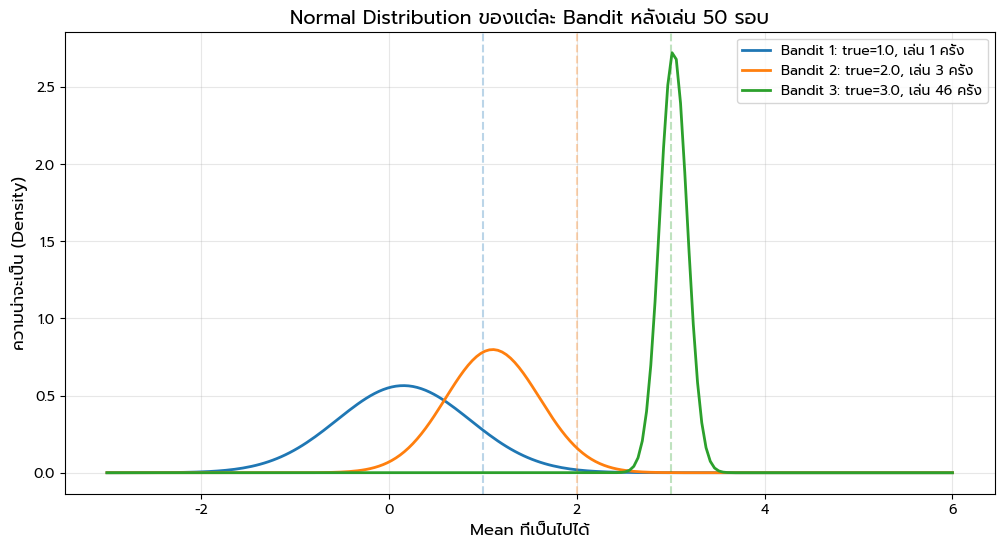


💡 สังเกต:
  - Bandit ที่เล่นบ่อย → กราฟแคบลง (มั่นใจมากขึ้น)
  - Peak ของกราฟค่อย ๆ เข้าใกล้เส้นประ (true mean)
  - Bandit 3 ควรมีกราฟที่แคบที่สุด (เล่นบ่อยสุด)


In [5]:
# วาดกราฟ Normal Distribution ของแต่ละ bandit
plt.figure(figsize=(12, 6))
x = np.linspace(-3, 6, 200)

for i, b in enumerate(bandits):
    # คำนวณ probability density
    y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
    plt.plot(x, y, label=f"Bandit {i+1}: true={b.true_mean:.1f}, เล่น {b.N} ครั้ง", linewidth=2)
    
    # แสดง true mean ด้วยเส้นประ
    plt.axvline(b.true_mean, color=f'C{i}', linestyle='--', alpha=0.3)

plt.xlabel('Mean ที่เป็นไปได้', fontsize=12)
plt.ylabel('ความน่าจะเป็น (Density)', fontsize=12)
plt.title(f'Normal Distribution ของแต่ละ Bandit หลังเล่น {NUM_TRIALS_SHORT} รอบ', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n💡 สังเกต:")
print("  - Bandit ที่เล่นบ่อย → กราฟแคบลง (มั่นใจมากขึ้น)")
print("  - Peak ของกราฟค่อย ๆ เข้าใกล้เส้นประ (true mean)")
print("  - Bandit 3 ควรมีกราฟที่แคบที่สุด (เล่นบ่อยสุด)")

## 🚀 Step 6: รันการทดลองเต็มรูปแบบ (2000 รอบ)

ตอนนี้เราจะใช้ฟังก์ชัน `run_experiment()` จากโค้ดต้นฉบับ

**ฟังก์ชันนี้จะ**:
1. เล่น 2000 รอบ
2. แสดงกราฟ Normal distribution ในหลาย ๆ จุด (5, 10, 20, 50, 100, 200, 500, 1000, 1500, 1999)
3. แสดงกราฟ cumulative average reward (ดูว่ารางวัลเฉลี่ยเข้าใกล้ค่าจริงไหม)

**เป้าหมาย**: Cumulative average ควรเข้าใกล้ 3 (mean ของ Bandit ที่ดีที่สุด)

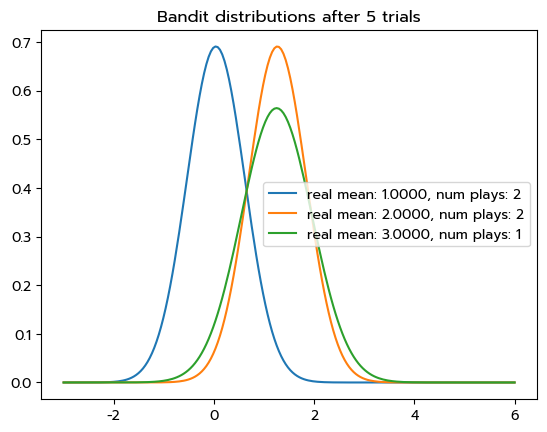

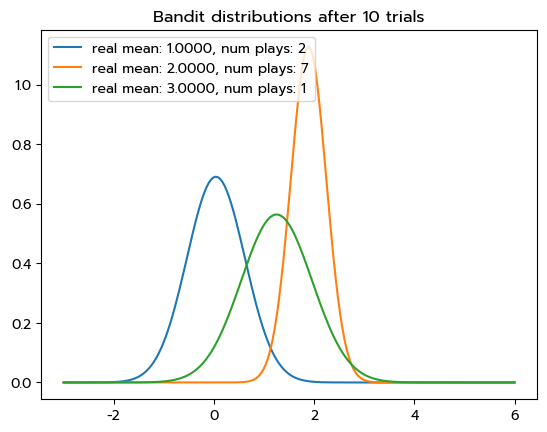

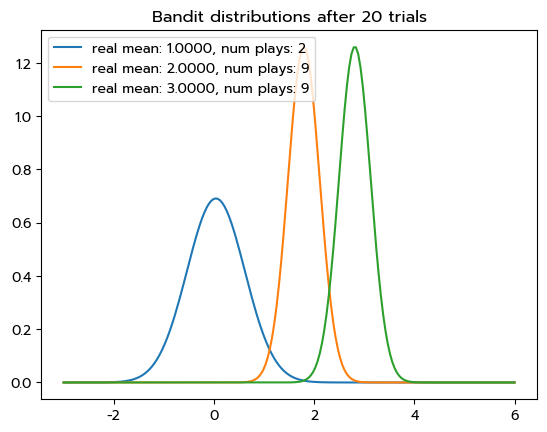

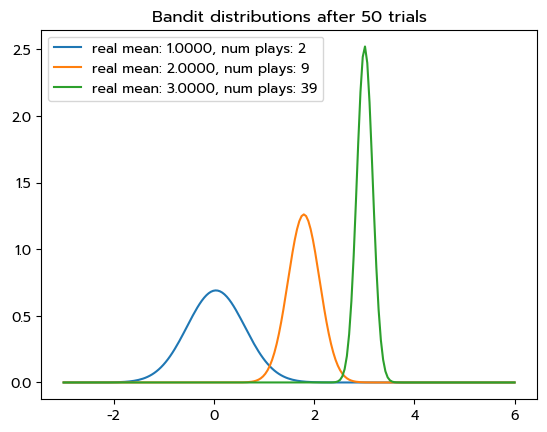

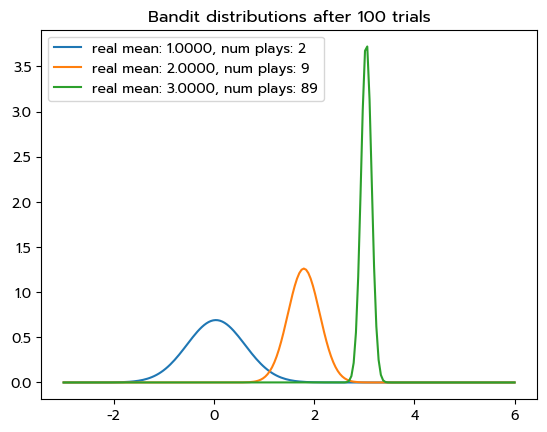

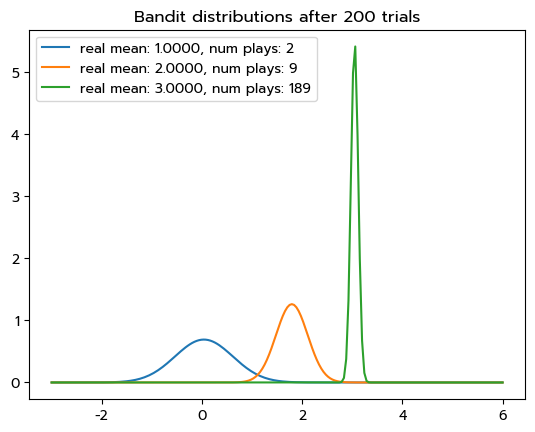

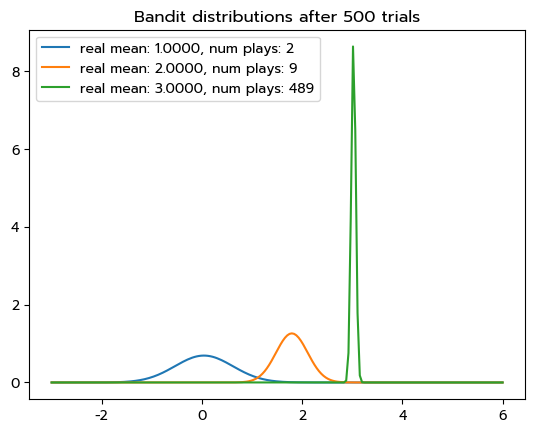

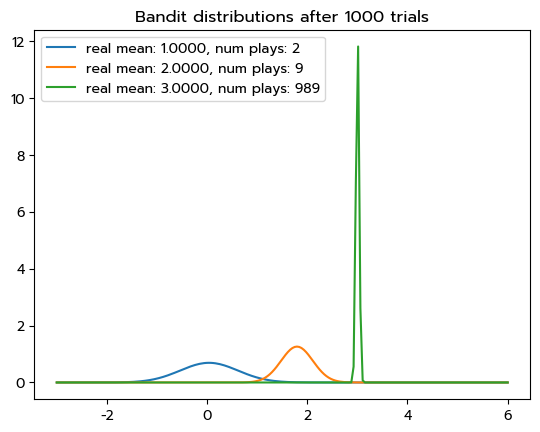

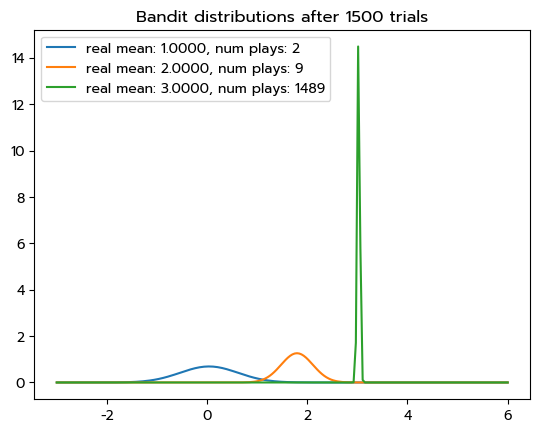

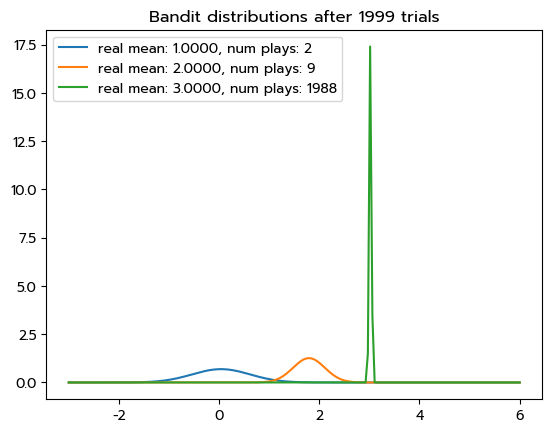

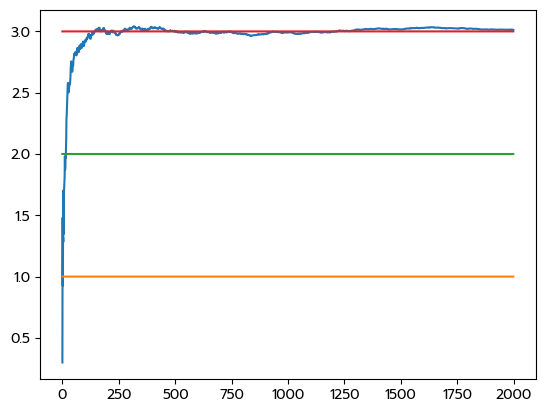


📊 สรุปผล:
  - Cumulative Average ท้ายสุด: 3.0129
  - เป้าหมาย (Best Bandit Mean): 3
  - ความแตกต่าง: 0.0129

✅ อัลกอริทึมสามารถหา Bandit ที่ดีที่สุดได้!


In [6]:
# รันการทดลองเต็มรูปแบบ
# จะแสดงกราฟหลาย ๆ รูป แสดงการเรียนรู้ในแต่ละช่วงเวลา
cumulative_avg = run_experiment()

print(f"\n📊 สรุปผล:")
print(f"  - Cumulative Average ท้ายสุด: {cumulative_avg[-1]:.4f}")
print(f"  - เป้าหมาย (Best Bandit Mean): {max(BANDIT_MEANS)}")
print(f"  - ความแตกต่าง: {abs(cumulative_avg[-1] - max(BANDIT_MEANS)):.4f}")
print(f"\n✅ อัลกอริทึมสามารถหา Bandit ที่ดีที่สุดได้!")

## 🎓 สรุป: สิ่งที่เราเรียนรู้

### 🔑 แนวคิดหลัก (Key Concepts):

1. **Bayesian Bandit สำหรับ Continuous Rewards**
   - ใช้เมื่อรางวัลเป็นตัวเลขจริง (revenue, time, ratings) ไม่ใช่แค่ success/failure
   - เรียนรู้ทั้ง **mean (μ)** และ **precision (λ)** ของแต่ละตัวเลือก

2. **Normal-Normal Conjugate Prior**
   - **Prior**: N(m=0, λ=1) → ไม่รู้อะไรเลย
   - **Likelihood**: N(true_mean, τ) → reward กระจายรอบค่าจริง
   - **Posterior**: N(m_new, λ_new) → อัพเดทแบบ Bayesian
   - **ข้อดี**: คำนวณง่าย มีสูตรปิด (closed-form)

3. **Bayesian Update สำหรับ Normal**
   ```
   m_new = (τ * x + λ * m) / (τ + λ)  → weighted average
   λ_new = λ + τ                       → precision เพิ่มขึ้นเรื่อย ๆ
   ```
   - ยิ่งมีข้อมูลมาก → λ สูง → กราฟแคบ → มั่นใจมากขึ้น

4. **Thompson Sampling Process**
   - สุ่มทาย mean จาก posterior N(m, 1/λ)
   - เลือกตัวที่สุ่มได้สูงสุด
   - อัพเดทความเชื่อหลังได้ reward

### 📊 ความแตกต่างจาก Beta-Bernoulli:

| Aspect | Beta-Bernoulli | Normal-Normal |
|--------|----------------|---------------|
| **Reward** | Binary (0 or 1) | Continuous (real number) |
| **Prior** | Beta(a, b) | Normal(m, λ) |
| **Update** | a += win, b += loss | m, λ update ตามสูตร |
| **Use Case** | Click rate, Conversion | Revenue, Ratings, Time |

### 💡 ข้อควรระวัง:

1. **Assumption**: สมมติว่า reward มาจาก Normal distribution
   - ถ้า reward เป็น skewed หรือมี outliers มาก → อาจไม่เหมาะ
   
2. **Fixed Precision (τ)**: เราสมมติว่า variance ของ reward เท่ากันทุก bandit
   - ในความเป็นจริงอาจไม่เป็นเช่นนั้น
   
3. **Exploration-Exploitation**: Thompson Sampling ยังคงสมดุลดีระหว่างลองของใหม่กับเลือกของดี

### 🌍 ใช้งานจริงได้ที่ไหน?

- 📊 **A/B Testing**: ทดสอบ feature ที่มีผลเป็น revenue, time spent
- ⭐ **Recommendation Systems**: เลือกแนะนำที่ให้ rating สูงสุด
- 💰 **Pricing Optimization**: หาราคาที่ให้กำไรเฉลี่ยสูงสุด
- 🎮 **Game Balancing**: ปรับพารามิเตอร์เกมให้ engagement time สูงสุด
- 📱 **Ad Bidding**: เลือกโฆษณาที่ให้ expected revenue สูงสุด

---

## 🎉 ขอแสดงความยินดี!

คุณเข้าใจ Bayesian Bandit สำหรับ Continuous Rewards แล้ว!  
นี่คือเครื่องมือที่ทรงพลังสำหรับการตัดสินใจในโลกจริงที่รางวัลไม่ได้เป็นแค่ชนะ/แพ้! 💪

**Next Steps**:
- ลองเปลี่ยน `BANDIT_MEANS` ดูว่าอัลกอริทึมเรียนรู้ยังไง
- ลองปรับ `tau` (precision ของ reward) ดูผลกระทบ
- เปรียบเทียบกับ UCB (Upper Confidence Bound) algorithm